<a href="https://colab.research.google.com/github/hmontaner/voice_verifier/blob/main/voice_verifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Voice Verifier

In this notebook we will create a model to verify speakers. Given two voice recordings A and B, the model will predict whether both voices belong to the same person or not. Note that the two sets of speakers used for training and testing are disjoint. Therefore, once trained, we expect the model to work with previously unheard speakers.

For this we will use Pytorch to create a [siamese neural network](https://en.wikipedia.org/wiki/Siamese_neural_network). This network is formed by a pair of identical sub-networks with the same weights. Each sub-network processes one of the voice recordings in the pair to analyse and outputs a tensor. The *distance* between those tensors is inversely proportional to the probability of belonging to different speakers. Similar models exists to verify face images, fingerprints, handwritten signatures, etc. For instance, some smartphones have a model trained to distinguish fingerprints; in this way, a smartphone can grant access to a user by telling if a new fingerprint reading is similar enough to the one which was used to set it up.


# Dataset Downlading and Preprocessing

Let's start by downloading some input data from [OpenSLR](http://www.openslr.org/12/). It contains multiple voice recordings of multiple people. We'll use a small development dataset in this notebook but feel free to use one of the larger training datasets if you are not in a hurry.

We won't directly feed our model with raw audio samples. Instead, to speed up the trainig, we'll preprocess those audios and extract some meaningful properties so that the model doesn't have to learn them.

This preprocessing takes some time but you can skip it by downloading an already processed dataset; just set `skip_preprocessing` to `True` in the next cell.

In [1]:
# Set this flag to True if you are in a hurry
skip_preprocessing = True
if not skip_preprocessing:
  !wget https://openslr.elda.org/resources/12/dev-clean.tar.gz
  # Once downloaded, let's extract the dataset.
  # The audio files (a few seconds long) are organised into multiple speaker subdirectories.
  !tar -xf dev-clean.tar.gz
else:
  !wget https://github.com/hmontaner/voice_verifier/raw/main/samples_dev-clean.zip
  !unzip -q -o samples_dev-clean.zip

--2024-01-11 14:25:40--  https://github.com/hmontaner/voice_verifier/raw/main/samples_dev-clean.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hmontaner/voice_verifier/main/samples_dev-clean.zip [following]
--2024-01-11 14:25:41--  https://raw.githubusercontent.com/hmontaner/voice_verifier/main/samples_dev-clean.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2194581 (2.1M) [application/zip]
Saving to: ‘samples_dev-clean.zip’

samples_dev-clean.z 100%[===================>]   2.09M  --.-KB/s    in 0.02s   

2024-01-11 14:25:41 (110 MB/s) - ‘samples_dev-clean.zip’ saved [2194581/21945

As we said, the raw audio samples have to be processed before feeding them to the model (unless you downloaded the already preprocessed dataset). [librosa](https://librosa.org) is a popular library we can use to extract some audio features.

In [2]:
# We'll use librosa to extract audio features. First we'll need to install its dependencies.
# Note that after installing the module you may have to restart the runtime.
%pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import librosa

def extractFeatures(file):
  y, sr = librosa.load(file, res_type="kaiser_fast")
  # Some features cannot be extracted from short samples
  if (librosa.get_duration(y=y, sr=sr) < 3):
    print("Skipping short sample: ", file)
    return
  # Feel free to experiment with other features:
  # https://librosa.org/doc/main/feature.html
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
  stft = np.abs(librosa.stft(y))
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
  mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T,axis=0)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T,axis=0)
  # Return the concatenation of all the properties
  features = np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis=0)
  return features

In [4]:
from pathlib import Path
import random

# subdir contains the voice samples of a given speaker
def processSamplesSubdir(target_dir, subdir):
  print("Starting with speaker", subdir.name)
  # Create the target directory where audio features will be stored
  sub_target_dir = target_dir / subdir.name
  sub_target_dir.mkdir(parents=True, exist_ok=True)
  # Pick a few random samples
  files = list(subdir.rglob("*.flac"))
  # Maximum number of samples considered for each speaker
  # Less samples can be used to speed up this notebook but it will impact the model
  num_samples_per_speaker = 50
  if len(files) > num_samples_per_speaker:
    files = random.sample(list(files), k=num_samples_per_speaker)
  # For each sample, extract its features and store them
  for sample in files:
    features = extractFeatures(sample)
    if features is not None:
      # Use numpy save to store the array of features
      np.save(sub_target_dir / sample.name, features)

In [5]:
import shutil

def processSamples(subdirs, target_dir):
  target_dir.mkdir(parents=True, exist_ok=True)
  # Clean the target directory
  for f in target_dir.glob("*"):
    shutil.rmtree(f)
  # Extract audio features of voice samples for each speaker.
  # Note this loop could be parallelised with joblib:
  # Parallel(n_jobs=4)(delayed(processSubdir)(target_dir, subdir) for subdir in subdirs)
  print(f'Processing {len(subdirs)} speakers')
  for subdir in subdirs:
    processSamplesSubdir(target_dir, subdir)

Let's prepare our dataset. We'll preprocess the audio files to extract some features. This is done just once, unless you want to experiment with different features. However, it can take a while so feel free to skip this step by setting `skip_extraction` to `True` as suggested in the first cell.

In [6]:
import sys

def process():
  # This is the directory created after extracting the downloaded dataset
  dir = "LibriSpeech/dev-clean"
  # Each subdirectory belongs to a different speaker
  subdirs = [f for f in Path(dir).iterdir() if f.is_dir()]
  if (len(subdirs) < 10):
    sys.exit("Not enough subdirectories found")

  # 80% for training, the rest for validation and test
  training_to = int(len(subdirs) * 0.8)
  validation_to = int(len(subdirs) * 0.9)
  training = subdirs[:training_to]
  validation = subdirs[training_to:validation_to]
  test = subdirs[validation_to:]

  # This may take a few minutes
  processSamples(training, Path("./samples/training"))
  processSamples(validation, Path("./samples/validation"))
  processSamples(test, Path("./samples/test"))

if not skip_preprocessing:
  process()
else:
  print("Skipping feature extraction")

Skipping feature extraction


# Data Loader

Once we have extracted the audio features, we need to define a [data set](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), that is, a Pytorch object to feed those audio features into the model.
As we will be using a [triplet loss function](https://en.wikipedia.org/wiki/Triplet_loss), each item in this dataset will be three samples: an anchor, a positive, and a negative.

In [7]:
import torch
from torch.utils.data import Dataset

class SiameseNetworkDataset(Dataset):
    def __init__(self, dir):
      subdirs = [f for f in dir.iterdir() if f.is_dir()]
      self.samples = dict()
      for subdir in subdirs:
          files = list(subdir.rglob("*.flac.npy"))
          self.samples[subdir.name] = files

    def getSubIndex(self, index):
        for k, v in self.samples.items():
            if index < len(v):
                return k, index
            index -= len(v)

    # Random sample of a speaker other than the sample to avoid if any
    def getPersonSample(self, person, index_to_avoid = None):
        while True:
          index = int(random.random() * len(self.samples[person]))
          if index != index_to_avoid:
              return self.samples[person][index]

    # Random person other than the one to avoid
    def getOtherPerson(self, person_to_avoid):
        while True:
            person = random.choice(list(self.samples.keys()))
            if person != person_to_avoid:
                return person

    def __getitem__(self, index):
        person, subindex = self.getSubIndex(index)
        # This dataset returns triplets:
        # 1. Anchor sample
        fileA = self.samples[person][subindex]
        # 2. Positive sample: same speaker as the anchor sample
        fileP = self.getPersonSample(person, subindex)
        # 3. Negative sample: different speaker from the anchor sample
        fileN = self.getPersonSample(self.getOtherPerson(person))
        # Use numpy load to read the three arrays of features
        sampleA = np.load(fileA)
        sampleP = np.load(fileP)
        sampleN = np.load(fileN)
        return torch.tensor(np.float32(sampleA)), torch.tensor(np.float32(sampleP)), torch.tensor(np.float32(sampleN))

    def __len__(self):
        return sum([len(s) for s in self.samples.values()])

# The Model

Now we can design the model litself. Even if we said this is a siamese network, here we define one single network. Later we'll just sequentially feed each of the samples in the triplets to this unique network.
Feel free to experiment with different layers, parameters, batch normalisations, etc. Note that larger networks may require larger datasets to avoid oferfitting.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):

    def __init__(self):
      super(SiameseNetwork, self).__init__()

      self.fc = nn.Sequential(
          nn.Linear(193, 1024*4),
          nn.Dropout(0.1),
          nn.ReLU(inplace=True),

          nn.Linear(1024*4, 1024),
          nn.ReLU(inplace=True),

          nn.Linear(1024, 32)
      )

    def forward(self, input):
        return self.fc(input)

Let's also define the loss function. In siamese networks, we typically use [Triplet Loss or Contrastive Loss](https://lilianweng.github.io/posts/2021-05-31-contrastive/). Here we'll use Triplet Loss because of the advantages described in [here](https://towardsdatascience.com/triplet-loss-advanced-intro-49a07b7d8905) (also because we empirically tested that contrastive loss results in worse accuracy):

*Notice that Triplet Loss does not have a side effect of urging to encode anchor and positive samples into the same point in the vector space as in Contrastive Loss. This lets Triplet Loss tolerate some intra-class variance, unlike Contrastive Loss, as the latter forces the distance between an anchor and any positive essentially to 0. In other terms, Triplet Loss allows to stretch clusters in such a way as to include outliers while still ensuring a margin between samples from different clusters, e.g., negative pairs.*

In [9]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1-x2).pow(2).sum(1)

    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

# Accuracy

Before starting with the training, let's define a few functions that will help us calculate the accuracy of the model. First we need a function to infer the distance between two voices using a given model.

In [10]:
def calc_euclidean(x1, x2):
    return (x1-x2).pow(2).sum(1)

def infer(dataloader, model):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  distancesP = list()
  distancesN = list()
  # For each batch of triplets
  for batch in iter(dataloader):
    sampleA = batch[0]
    sampleP = batch[1]
    sampleN = batch[2]
    # run each voice sample through the model
    outputA = model(sampleA.to(device))
    outputP = model(sampleP.to(device))
    outputN = model(sampleN.to(device))
    # and calculate distances for the positive and negative pairs
    distancesP += calc_euclidean(outputA, outputP)
    distancesN += calc_euclidean(outputA, outputN)
  return distancesP, distancesN

The result of our model is a distance between a pair of voices. We should calculate a distance threshold below which a pair of voices are considered to belong to the same person.
It could be done by eyeballing some result experiments but here we calculate the optimum to automatise the process.

In [11]:
# Get the proportion of samples that are correctly predicted assuming the given threshold
def getAccuracy(inferencesP, inferencesN, threshold):
  num_correct_predictions = 0
  num_correct_predictions += sum(distance < threshold for distance in inferencesP)
  num_correct_predictions += sum(distance >= threshold for distance in inferencesN)
  return num_correct_predictions / (len(inferencesP + inferencesN))

import itertools
# Get the threshold that maximises accuracy using brute force.
# TODO: optimise
def getMaximum(inferencesP, inferencesN):
  max_accuracy = 0
  for i in itertools.chain(inferencesP, inferencesN):
    accuracy = getAccuracy(inferencesP, inferencesN, i.item())
    max_accuracy = max(max_accuracy, accuracy)
  return max_accuracy

Let's also create a plot to help us understand the performance of our model.

In [12]:
from matplotlib import pyplot as plt
def plotInferences(inferencesP, inferencesN):
  same = list(map(lambda i: i.item(), inferencesP))
  difference = list(map(lambda i: i.item(), inferencesN))
  all = itertools.chain(same, difference)
  num_bins = 100
  bin_width = max(all) / num_bins
  bins = np.arange(0, num_bins * bin_width, bin_width)
  plt.hist(same, alpha=0.5, label='Same voice', bins=bins)
  plt.hist(difference, alpha=0.5, label='Different voice', bins=bins)
  plt.ylabel('Frequency')
  plt.xlabel('Distance')
  plt.title('Voice distances')
  plt.show()

This last helper function checks the accuracy of the model on a given dataset. It will be used while training to see the evolution of the model.

In [13]:
from torch.utils.data import DataLoader
def checkAccuracy(dir, model, show_plot = False):
  dataset = SiameseNetworkDataset(dir=dir)
  dataloader = DataLoader(dataset, shuffle=True, num_workers=1, batch_size=64)
  # First get inference results
  inferencesP, inferencesN = infer(dataloader, model)
  # Then draw a plot, find the optimum threshold, and calculate its accuracy
  if show_plot:
    plotInferences(inferencesP, inferencesN)
  accuracy = getMaximum(inferencesP, inferencesN)
  return accuracy

# Training
Now we can train the model. For that, we first create a data loader and instantiate the siamese network, the triplet loss, and an optimiser. Then, for each epoch, we read a batch of triplets from the data loader and pass each of the three samples to the model. The three outputs of the model are used to calculate the loss that, in turn, is used to optimise the network.
The model will learn how to output a tensor that describes the unique characteristics of the given voice. The output tensors will be *similar* for two voices of the same speaker.

In [29]:
from torch import optim

training_dir = Path("samples/training")
siamese_dataset = SiameseNetworkDataset(dir=training_dir)
print("Size of dataset: ", len(siamese_dataset))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

train_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=2, batch_size=128)
net = SiameseNetwork().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# Record losses and accuracies to draw a nice graph
losses = []
test_accuracies = []
training_accuracies = []

Size of dataset:  1377
Device: cuda


Feel free to rerun the next cell as many times as you like until the model converges. With 50 epochs, the model should reach nearly 90% accuracy.

In [30]:
for epoch in range(50):
  loss = None
  for i, (sampleA, sampleP, sampleN) in enumerate(train_dataloader):
    optimizer.zero_grad()
    # Anchor sample
    outputA = net(sampleA.to(device))
    # Positive sample (same speaker)
    outputP = net(sampleP.to(device))
    # Negative sample (different speaker)
    outputN = net(sampleN.to(device))
    loss = criterion(outputA, outputP, outputN)
    loss.backward()
    optimizer.step()

  # After each epoch, check and record accuracies
  losses.append(loss.item())
  test_accuracy = checkAccuracy(Path("samples/test"), net).cpu()
  test_accuracies.append(test_accuracy)
  # Training accuracy is commented out to speed up the training
  #training_accuracy = checkAccuracy(Path("samples/training"), net).cpu()
  #training_accuracies.append(training_accuracy)
  print(f'Epoch {epoch}: loss {loss.item()}, test accuracy {test_accuracy}')

Epoch 0: loss 4.6988959312438965, test accuracy 0.6583850979804993
Epoch 1: loss 1.8572735786437988, test accuracy 0.6521739363670349
Epoch 2: loss 2.9670522212982178, test accuracy 0.7049689292907715
Epoch 3: loss 2.4187498092651367, test accuracy 0.7267081141471863
Epoch 4: loss 1.5449026823043823, test accuracy 0.739130437374115
Epoch 5: loss 0.412008136510849, test accuracy 0.7763975262641907
Epoch 6: loss 1.1506541967391968, test accuracy 0.7515528202056885
Epoch 7: loss 0.680703341960907, test accuracy 0.7732919454574585
Epoch 8: loss 0.9048100113868713, test accuracy 0.7515528202056885
Epoch 9: loss 0.4967648386955261, test accuracy 0.7701863646507263
Epoch 10: loss 1.8876206874847412, test accuracy 0.7763975262641907
Epoch 11: loss 0.05337996035814285, test accuracy 0.8136646151542664
Epoch 12: loss 0.27603086829185486, test accuracy 0.8105590343475342
Epoch 13: loss 1.256568431854248, test accuracy 0.7950310707092285
Epoch 14: loss 0.5371984243392944, test accuracy 0.816770195

# Result Graphs

Before ploting the graphs of your model, let's see an example of a model that has been trained with the large dataset (this model is slightly larger than the one proposed in this notebook because overfitting is less probable with the large dataset).

In this first graph we can see the evolution of the training. With the large dataset we can achieve around **92% accuracy** in the test dataset (blue line), while we achieve 94% accuracy in the training dataset (red line). Note this can take a few hours to train.

![plot_training.png](https://github.com/hmontaner/voice_verifier/blob/main/plot_training.png?raw=true)

This other graph represents how the test dataset is interpreted by the trained model. Blue bars show the amount of voice pairs belonging to the same person and orange bars show the amount of pairs belonging to different persons. The model has learned to output a small distance (near zero) between same-person voices while it outputs a distance around 15 for different-person voices.

![plot_distances.png](https://github.com/hmontaner/voice_verifier/blob/main/plot_distances.png?raw=true)

Finally, let's see how the training of your model went:

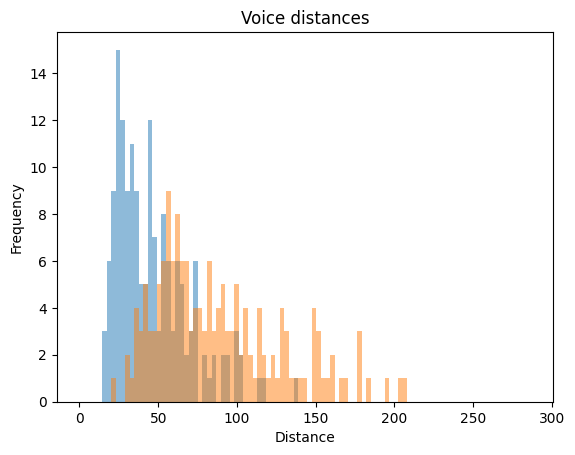

Accuracy: 0.7561728358268738


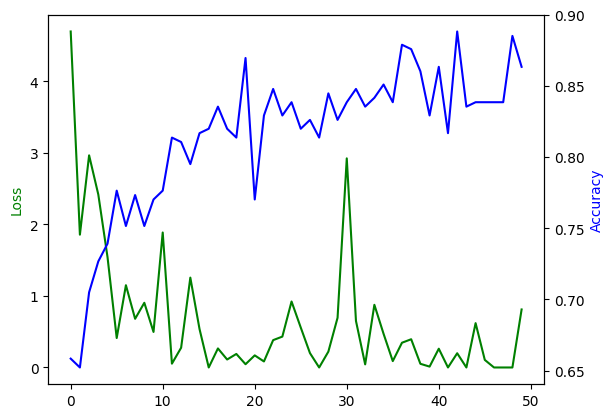

In [31]:
# This plots the loss and accuracy evolution through training
fig, ax1 = plt.subplots()
xs1 = [x for x in range(len(losses))]
ax1.plot(xs1, losses, 'g-')
xs2 = [x * len(losses)/len(test_accuracies) for x in range(len(test_accuracies))]
ax2 = ax1.twinx()
ax2.plot(xs2, list(map(lambda x: x.cpu(), test_accuracies)), 'b-')
if len(training_accuracies) > 0:
  ax2.plot(xs2, list(map(lambda x: x.cpu(), training_accuracies)), 'r-')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Accuracy', color='b')
plt.show()

# This plots the accuracy histogam
accuracy = checkAccuracy(Path("samples/validation"), net, show_plot = True)
print(f'Accuracy: {accuracy}')